# 3.4 Climate Model Output

Up until now, this chapter has focused on acquiring and analyzing climate data from observations, or reanalysis data which assimilates observational data into a weather forecast model. These sources of data are only half of the story. Since this guide is about climate change projections, we must also learn how to download and process output from climate model simulations. 

Output from climate models that was submitted to the CMIP projects has been made publicly available for download from the [Earth System Grid Federation (ESGF)](https://esgf.llnl.gov/). The ESGF is a peer-to-peer network with nodes hosted by several research centres around the world. The archive of data hosted on a given node can be searched and naviagted in a browser. The website for the node hosted at Lawrence Livermore National Laboratory in the USA can be found [at this link](https://esgf-node.llnl.gov/projects/esgf-llnl/), and links for all of the nodes can be found [here](https://esgf.llnl.gov/nodes.html). Via the browser interface, one can populate their data cart like an online store and generate a `wget` script that when executed, will download the selected data. However, this process can be somewhat cumbersome if you are interested in large amounts of data, or if you wish to create an automated workflow. For advanced users, the ESGF offers a RESTful API, which is outside the scope of this guide. In this guide we will use the Python package ([esgf-pyclient](https://esgf-pyclient.readthedocs.io/en/latest/index.html)) (also called `pyesgf`) as an interface to the API. With `pyesgf`, one can either get an OPeNDAP URL to access the data directly, or get a URL from which the data can be downloaded using the Python `requests` library.

[Complete documentation for the ESGF, and all options for accessing the data, can be found here](https://esgf.github.io/esgf-user-support/index.html).


As with the reanalysis and gridded observations, climate model output is typically very large in volume. For this reason, we will show examples in this notebook using monthly means instead of daily means or 6-hourly instananeous output, which is typically required for climate impact analysis.

## 3.4.1 Searching For Data
To search the ESGF archive we must first establish a connection to an ESGF node using the `pyesgf.search.SearchConnection` class. To do this, we pass the URL for the node to `SearchConnection`. Since each node may only host a subset of the complete CMIP archive, the argument `distrib = True` tells the API to search across all nodes, not just the one we connected to.

Note: There are sometimes network/service issues with the ESGF nodes, meaning you may sometimes get unexpected errors when using esgf-pyclient. You can try connecting to a different node, or waiting and trying to run the code later. The URLs for each of the nodes, and their operating status, can be found [on this page](https://esgf-node.llnl.gov/status/).

In [1]:
# import the required packages
from pyesgf.search import SearchConnection
import os
import requests
from tqdm import tqdm
import ec3

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

# use this to suppress a warning which we can ignore
os.environ["ESGF_PYCLIENT_NO_FACETS_STAR_WARNING"] = "on"

In [2]:
# establish a connection to the LLNL node
conn = SearchConnection('https://esgf-node.llnl.gov/esg-search', distrib=True)

# if that doesn't work, try the UK node
#conn = SearchConnection('https://esgf.ceda.ac.uk/esg-search', distrib=True)

After connecting to a node we need to decide which data we'd like to access. The search function takes a number of different search parameters (also called *facets*), listed and described in the table below. Unfortunately, the names for some of the search parameters are different for the CMIP5 and CMIP6 archives, so both are included in the table.

|                   Search Criterion                   |    CMIP5 Name    |         CMIP6 Name        |
|:----------------------------------------------------:|:----------------:|:-------------------------:|
|          Project (i.e. CMIP6, CORDEX, etc.)          |     `project`    |         `project`         |
|                      Model Name                      |      `model`     |        `source_id`        |
|                    Time Frequency                    | `time_frequency` | `table_id` or `frequency` |
|                   Forcing Scenario                   |   `experiment`   |      `experiment_id`      |
|                       Variable                       |    `variable`    |       `Variable ID`       |
|                    Ensemble Member                   |    `ensemble`    |        `member_id`        |
| Climate domain (i.e. atmosphere, ocean,  land, etc.) |      `realm`     |          `realm`          |


To include multiple values for a search parameter (e.g. if you want data for both historical and SSP5-8.5 forcing scenarios), you can separate the search keywords with a comma (e.g. `experiment_id = 'historical,ssp585'`. Let's do exactly this, searching for `tas` (surface air temperature) data at monthly frequency from the model `CanESM5`, the Canadian model contributing to CMIP6. To limit the amount of data involved, we'll also select only a single ensemble member, instead of the whole ensemble. Dropping the search parameter `member_id` would make the search return results for all ensemble members (if there are multiple members for the model(s)/experiment(s) of interest).


In [3]:
query = conn.new_context(latest = True, # search for most recent versions of the file
                         project="CMIP6",
                         experiment_id='historical,ssp585',
                         source_id = "CanESM5",
                         frequency = 'mon', # monthly ('day' for daily, '6hr' for 6-hourly, etc.)
                         member_id="r1i1p1f1",
                         variable_id = "tas")
results = query.search()

len(results)

12

Our search returned 12 results, meaning 12 different data files match our search criteria. The results still need a bit more processing until we can get the download URLs (or OPeNDAP URLs) for the data. Next we'll do this processing, and make a `pd.DataFrame` mapping the file names to the URLs.



In [4]:
# sometimes running this cell raises an error, but running it a second time seems to work.
files = []
for i in range(len(results)):
    hit = results[i].file_context().search()
    files += list(map(lambda f: {'filename': f.filename, 
                                 'download_url': f.download_url, 
                                 'opendap_url': f.opendap_url}, hit))
files = pd.DataFrame.from_dict(files)
len(files)

24

We now have a list of 24 files that match our search criteria. This might be a result of the distributed search returning the same data files, hosted on different nodes. Let's print out all of the file names to check for duplicates, before we do any downloading

In [5]:
for fname in files['filename'].sort_values(): # print in alphabetical order
    print(fname)

tas_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc
tas_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc
tas_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc
tas_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc
tas_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc
tas_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc
tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc
tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc
tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc
tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc
tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc
tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc
tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_210101-218012.nc
tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_210101-218012.nc
tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_210101-218012.nc
tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_210101-218012.nc
tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_210101-218012.nc
tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_210101-218012.nc
tas_Amon_CanESM5_ssp58

As suspected, there are duplicates of each file - we really only want 4 files here. One for the historical experiment, and three for different time periods of the SSP5-8.5 experiment. 

In [6]:
# filter the DataFrame to drop duplicate filenames
files = files.drop_duplicates('filename')
files

,filename,download_url,opendap_url
0,tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_201501-210...,http://crd-esgf-drc.ec.gc.ca/thredds/fileServe...,http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esg...
1,tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_210101-218...,http://crd-esgf-drc.ec.gc.ca/thredds/fileServe...,http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esg...
2,tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_218101-230...,http://crd-esgf-drc.ec.gc.ca/thredds/fileServe...,http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esg...
3,tas_Amon_CanESM5_historical_r1i1p1f1_gn_185001...,http://aims3.llnl.gov/thredds/fileServer/css03...,http://aims3.llnl.gov/thredds/dodsC/css03_data...


## 3.4.2 Downloading Data

We are now ready to access the data, either directly with `xarray` and the OPenDAP URL, or by downloading and saving the file locally. Since we already know how to do the former, we will do the latter. If you don't want to save the data in the current working directory, append filename to the path to the directory you'd like to write the data to using `os.path.join()`.

In [7]:
# Adapted from: https://stackoverflow.com/a/37573701
def download(url, filename):
    """
    Download a file hosted at <url> and write to <filename>
    """
    print("Downloading ", filename)
    r = requests.get(url, stream=True)
    total_size, block_size = int(r.headers.get('content-length', 0)), 1024
    with open(filename, 'wb') as f:
        for data in tqdm(r.iter_content(block_size),
                         total=total_size//block_size,
                         unit='KiB', unit_scale=True):
            f.write(data)

    if total_size != 0 and os.path.getsize(filename) != total_size:
        print("Downloaded size does not match expected size!\n",
              "FYI, the status code was ", r.status_code)

In [8]:
# create a directory (inside the current working directory) to save the data to
data_directory = "CanESM5_tas_monthly"
if not os.path.exists(data_directory): # only make the directory if it doesn't already exist
    os.mkdir(data_directory)



In [9]:
# download the data, one file at a time
for i in range(len(files)):
    url = files['download_url'].loc[i]
    filename = files['filename'].loc[i]
    path_to_write = os.path.join(data_directory, filename)
    
    # only download if the files doesn't already exist. 
    if not os.path.exists(path_to_write): 
        download(url, path_to_write)
    
    # if there is an error downloading a file, you'll need to either delete the file,
    # or change this block of code to call download(url, path_to_write) without 
    # first checking if path_to_write exists,

Sometimes there are issues downloading files from the ESGF, due to technical errors on their end. One way to ensure that the file downloaded successfully is to check the file size. For monthly data, we expect each file to be a few tens of MB, so if the file size is much smaller, there was likely a problem. This will get flagged in the `download` function we used to download the data, but we can also check the file size using the `os.stat` function, as demonstrated below:

In [10]:
# loop through each file, just like when we downloaded them
for i in range(len(files)):
    filename = files['filename'].loc[i]
    filepath = os.path.join(data_directory, filename)
    filestats = os.stat(filepath)
    size_in_MB = filestats.st_size / 1e6 # convert bytes to megabytes
    print(f"Size of {filename}: {size_in_MB} MB")

Size of tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc: 27.267498 MB
Size of tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_210101-218012.nc: 25.23234 MB
Size of tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_218101-230012.nc: 37.722355 MB
Size of tas_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc: 52.443019 MB


The size of each downloaded file is as expected, so we will proceed. If the rest of the notebook runs without error, then that's another sign that the download was successful.

## 3.4.3 Opening and Exploring the Data

Now that the files are downloaded and saved, we can open them directly with `xarray` and do some analysis. Let's plot a time series of temperature near Toronto for the whole record, and compare the historical data to the Toronto City station observations (from Section 3.1). 

In [11]:
# first open the CanESM5 data, all files at once - open_mfdataset will automatically concatenate them in time
ds_CanESM5 = xr.open_mfdataset(data_directory + "/*.nc")

In [12]:
# now get obs data - this function is copied and modified from Section 3.1

stn_ids_toronto_city = [5051, 31688, 41863]
df_list = []
for i, stn_id in enumerate(stn_ids_toronto_city):
    df = ec3.get_data(stn_id, 
                      type = 3, # monthly mean data
                      progress = False)
    if i > 0: # ensure no duplicate times
        df = df[df['Date/Time'] < df_list[i-1]['Date/Time'].min()]
    df_list.append(df)

df_obs = pd.concat(df_list, axis = 0)


column_name_dict = {'Date/Time': 'time', 
                    'Mean Temp (°C)': 'tas',
                    'Latitude (y)': 'lat',
                    'Longitude (x)': 'lon',
                    'Station Name': 'Name'}
    
df_obs = df_obs.rename(columns = column_name_dict)
df_obs = df_obs[list(column_name_dict.values())]
df_obs['time'] = pd.to_datetime(df_obs['time'])
df_obs = df_obs.set_index("time")
    
# sort the data in proper chronological order
df_obs = df_obs.sort_index()

# select data only up to 2015, when the "historical" simulation ends
df_obs = df_obs[df_obs.index.year.isin(range(1850, 2015))]

print(df_obs.index.min(), df_obs.index.max())

1850-01-01 00:00:00 2006-12-01 00:00:00


The monthly data for this station ends at the end of 2006, but we'll proceed anyways. Since we know there is daily data up until the present, best practice would be to calculate monthly means from the daily means (weighted by the number of days in the month), but we digress.

In [13]:
# interpolate the CanESM5 model data to the station location
station_lat = df_obs['lat'][0]
station_lon = df_obs['lon'][0] + 360 # model data longitudes go from (0, 360) instead of (-180, 180)

tas_CanESM5 = ds_CanESM5.tas.interp(lat = station_lat, lon = station_lon) - 273.15

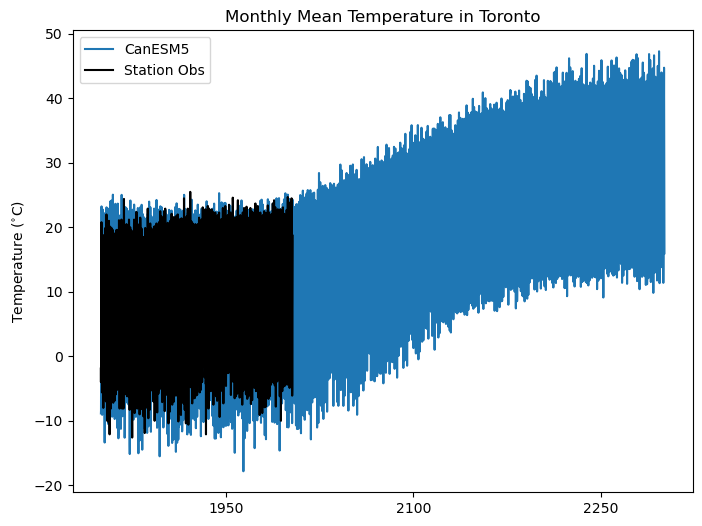

In [14]:
# station and model data have different time datatypes, so make a time axis with
# xarray to use for the obs
times_obs = xr.cftime_range(start = df_obs.index.min(), 
                            # need to add an extra month to the endpoint to make it closed at the right
                            end = df_obs.index.max() + pd.Timedelta(days=30), 
                            freq = 'M', calendar = 'noleap')
# plot the time series
fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(tas_CanESM5.time.values, tas_CanESM5, label = 'CanESM5')
ax.plot(times_obs, df_obs['tas'], color = 'k', linestyle = '-', label = 'Station Obs')
ax.set_title("Monthly Mean Temperature in Toronto")
ax.set_ylabel(r"Temperature ($^{\circ}$C)")
plt.legend()
plt.show()

While we should not expect the individual months of the simulated data to match up with the station observations, the degree of overlap is encouraging that the model agrees decently well with observations. 

## 3.4.4 Basic Exploration of Model Bias

To better quantify this, we can plot the probability distribution of each dataset during their common period, and calculate metrics such as the mean bias. Because the model has lower minima than the observations, we might expect it to be biased cold (i.e. negative mean bias). It also has slightly more maxima that exceed the observations, so perhaps it also has a higher standard deviation. Let's calculate these metrics and add them to the distribution plot.

In [15]:
# select model data during obs period
obs_year_range = range(times_obs.year.min(), times_obs.year.max() + 1) # add one so the range includes the max year
tas_CanESM5_obsperiod = tas_CanESM5.sel(time = tas_CanESM5.time.dt.year.isin(obs_year_range))

# fit Kernel Density Estimator so we can plot a smooth distribution
kde_CanESM5 = stats.gaussian_kde(tas_CanESM5_obsperiod.values)
kde_obs = stats.gaussian_kde(df_obs['tas'].dropna().values) # need to drop missing values or else scipy complains


# mean values for each dataset
tas_CanESM5_mean = tas_CanESM5_obsperiod.mean('time')
tas_obs_mean = df_obs['tas'].mean()

# stdevs for each dataset
tas_CanESM5_stdev = tas_CanESM5_obsperiod.std('time')
tas_obs_stdev = df_obs['tas'].std()

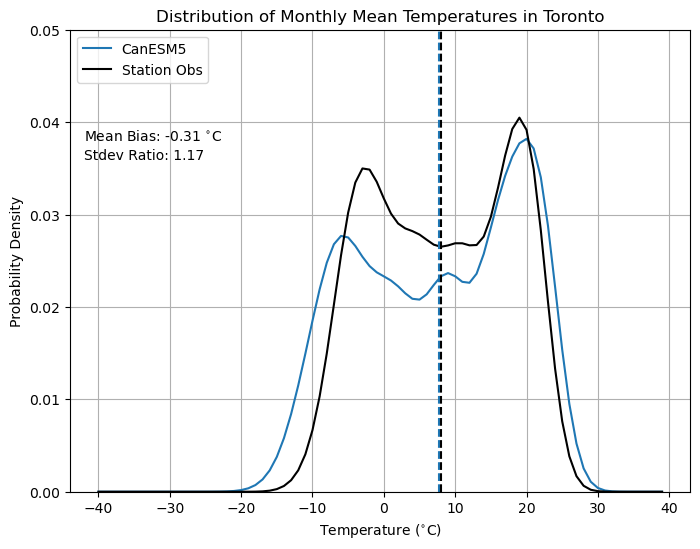

In [16]:
# range of temperatures to plot
temperatures = np.arange(-40, 40)
plt.figure(figsize = (8,6))
plt.title("Distribution of Monthly Mean Temperatures in Toronto")
plt.plot(temperatures, kde_CanESM5(temperatures), label = 'CanESM5')
plt.plot(temperatures, kde_obs(temperatures), label = 'Station Obs', color = 'k')
plt.vlines([tas_CanESM5_mean, tas_obs_mean], 0, 1, colors = ['tab:blue', 'k'], linestyles = '--')
plt.ylim(0, 0.05)
plt.xlabel(r"Temperature ($^{\circ}$C)")
plt.ylabel("Probability Density")
plt.legend(loc = 'upper left')
plt.grid()

# annotate with mean bias and ratio of stdevs
plt.text(-42, 0.038, r'Mean Bias: %.2f $^{\circ}$C' % (tas_CanESM5_mean - tas_obs_mean))
plt.text(-42, 0.036, r'Stdev Ratio: %.2f' % (tas_CanESM5_stdev / tas_obs_stdev))

plt.show()

Indeed the model data for this location is biased slightly low, and has too high of a standard deviation, compared to the station observations. For sub-monthly data, these biases could possibly be worse, which is one reason why downscaling and bias-correction is a necessary part of climate impact analysis.

An interesting feature of these distributions of temperature is that they are *bimodal*, meaning there are two maxima. This is likely because of the seasonal cycle - the peak near lower temperatures is for cold-season months, and the other is for the warm season. For this reason, we often separate the data by month or by season when quantifying biases (at least for variables that have a strong seasonal cycle). Let's do this by comparing the monthly climatologies of the two datatsets.

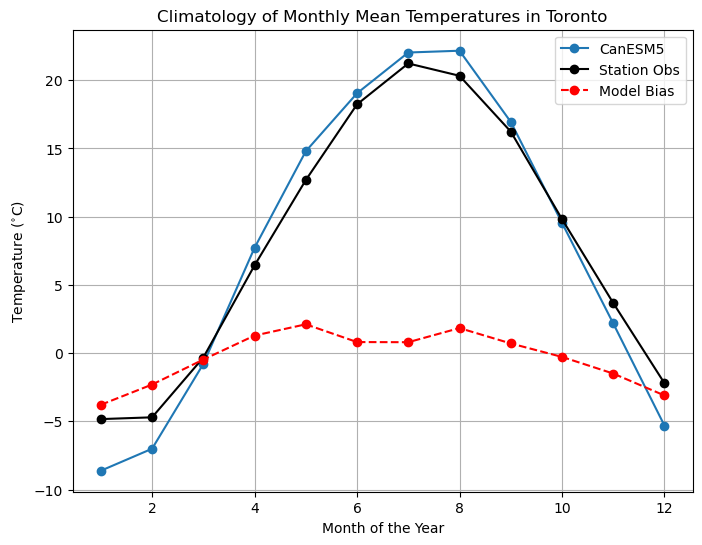

In [17]:
# calculate monthly climatologies
tas_monthlyclim_CanESM5 = tas_CanESM5_obsperiod.groupby('time.month').mean('time')
tas_monthlyclim_obs = df_obs['tas'].groupby(df_obs.index.month).mean()

# difference in climatologies
monthlyclim_bias = tas_monthlyclim_CanESM5.values - tas_monthlyclim_obs.values

months = tas_monthlyclim_CanESM5.month.values 

# plot
plt.figure(figsize = (8,6))
plt.title("Climatology of Monthly Mean Temperatures in Toronto")
plt.plot(months, tas_monthlyclim_CanESM5, label = 'CanESM5', marker = 'o')
plt.plot(months, tas_monthlyclim_obs, label = 'Station Obs', color = 'k', marker = 'o')
plt.plot(months, monthlyclim_bias, label = 'Model Bias', color = 'red', linestyle = '--', marker = 'o')
plt.xlabel("Month of the Year")
plt.ylabel(r"Temperature ($^{\circ}$C)")
plt.legend()
plt.grid()
plt.show()

This plot is much more informative! The overall negative mean bias is due to overly cold winter months, but the summer months are also slightly too hot. This is why the model data higher standard deviation than the observations. For a variable with a strong seasonal cycle like temperature, bias correction should be done with data grouped by the day or month of the year, to account for seasonally-varying biases.


## 3.4.5 Significance Testing for Trends and Changes

When analyzing future climate projections, an important question to ask early in your study is whether your climate variables of interest show significant trends or changes over the time horizon you plan to study. If, for example, you are interested in using precipitation data to drive a hydrology model and investigate how flooding might change for a certain catchment under climate change, but the changes to precipitation in your study area are not statistically significant, then your impact study will likely also have a null result. 

### 3.4.5.1 Discrete Changes (Deltas)

There are a number of methods that climate scientists use to assess if climate change signals are significant. These methods range in complexity and statistical robustness. The simplest method would be to calculate the climatological standard deviation for the historical period, and check if the projected mean change falls outside the one-sigma range. This method does not account for possible changes to the variance in the future period, the form of the distributions of the data (i.e. non-Gaussian variables like precipitation or wind speed), and is not very statistically robust. This extraordinarily simple method should only be used as a first rough assessment, and should not give much confidence that the changes are truly statistically significant.

The next best way to test if a mean change is statistically significant is the two sample Student's [$t$-test](https://en.wikipedia.org/wiki/Student%27s_t-test). This is a very common statistical test, used to assess if two different sets of data have different mean values. For large datasets, the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) tells us that the distribution of the sample mean tends towards a Gaussian distribution even for non-Gaussian variables, so we don't usually need to be concerned about the assumption of Gaussian distributions inherent to the $t$-test. However, we *do* need to be concerned about the assumption that each sample is *independent*. With time series data, especially climate time series data, there are nearly always significant serial dependence in the data. In other words, today's weather is strongly related to yesterday's weather, which means that data points close in time are not statistically independent of each other. For serially correlated data, the number of independent samples is not equal to the actual total number of samples. We instead calculate an *effective sample size* using the following formula ([Wilks, 2011](https://librarysearch.library.utoronto.ca/permalink/01UTORONTO_INST/14bjeso/alma991106907255706196)):

$$N_{eff} = N \frac{1 - \rho_{1}}{1 + \rho_{1}} $$


Where $\rho_{1}$ is the *lag-one temporal autocorrelation* of the time series. For a time series $x(t)$ with time step $\Delta t$, this is the correlation between $x(t)$ and $x(t-\Delta t)$. 

Using the effective sample size correction, let's use the two sample Student's $t$-test to check if the monthly mean temperatures for Toronto in CanESM5 change significantly from the 1971-2000 period to the 2071-2100 period.

In [18]:
# select historical and future periods
tas_CanESM5_hist = tas_CanESM5.sel(time = tas_CanESM5.time.dt.year.isin(range(1971, 2001)))
tas_CanESM5_future = tas_CanESM5.sel(time = tas_CanESM5.time.dt.year.isin(range(2071, 2101)))


In [19]:
# calculate effective sample size for historical and future periods
def effective_sample_size(data):
    ntime = len(data.time)
    # times not including the final timestep
    times = data.time.isel(time = slice(0, ntime - 1))
    # data not including the first timestep
    data_lag = data.isel(time = slice(1, ntime))
    # match up time values, otherwise the xr.corr function won't return the correct output
    data_lag = data_lag.assign_coords(time = times)
    
    # calculate correlation
    autocor = xr.corr(data.sel(time = times),
                      data_lag,
                      dim = 'time')
    
    neff = ntime * (1 - autocor) / (1 + autocor)
    
    return neff

neff_hist = effective_sample_size(tas_CanESM5_hist)
neff_future = effective_sample_size(tas_CanESM5_future)

In [20]:
# calculate means and stdevs for each period
tas_CanESM5_hist_mean = tas_CanESM5_hist.mean('time')
tas_CanESM5_future_mean = tas_CanESM5_future.mean('time')

tas_CanESM5_hist_std = tas_CanESM5_hist.std('time')
tas_CanESM5_future_std = tas_CanESM5_future.std('time')

# perform two_sample t-test to see if future temperatures are higher than past
tstat, pval_neff = stats.ttest_ind_from_stats(tas_CanESM5_hist_mean,
                                              tas_CanESM5_hist_std,
                                              neff_hist,
                                              tas_CanESM5_future_mean, 
                                              tas_CanESM5_future_std, 
                                              neff_future,
                                              equal_var = False,
                                              alternative = 'less') 
# alt hypothesis is that the first dataset (historical) has a lower mean than the second dataset (future)

# do it again using the total sample size, to demonstrate how the p-value will be underestimated
tstat, pval_ntot = stats.ttest_ind_from_stats(tas_CanESM5_hist_mean,
                                              tas_CanESM5_hist_std,
                                              len(tas_CanESM5_hist.time),
                                              tas_CanESM5_future_mean, 
                                              tas_CanESM5_future_std, 
                                              len(tas_CanESM5_future.time),
                                              equal_var = False,
                                              alternative = 'less')

# print each p-value to 6 significant figures
print("Total Sample Size p-value: %.6f" % pval_ntot)
print("Effective Sample Size p-value: %.6f" % pval_neff)

Total Sample Size p-value: 0.000000


Effective Sample Size p-value: 0.001478


Comparing the p-values calculating using the total sample size and the effective sample size confirms that failing to account for serial dependence in the data leads to overconfidence in the significance of results. For this case, the mean change is still significant after accounting for serial dependence, but this may not always be the true. If the lag-1 autocorrelation is big enough, or if the magnitude of the change is small enough, then failing to correct for the influence of serial dependence might lead you to mistake a null result for a significant one.

### 3.4.5.2 Trends

Sometimes a climate study might not focus on differences between a future and historical time period, but instead focus on rates of change of a certain variable, i.e. a trend. Your first thought might be to use ordinary least squares to do a linear regression and test for significance of the slope parameter, but this will result in a similar issue to the one we just worked through. Ordinary linear regression assumes that all of the data samples are independent, so the presence of serial correlations will inflate the p-value. Additionally, many climate trends are nonlinear. Even global mean surface air temperature, possibly the most studied and well-understood climate variable, has been shown to have an accelerating trend over the past several decades ([Gulev et al., 2021](https://www.ipcc.ch/report/ar6/wg1/chapter/chapter-2/)). For these reasons, more robust statistical tests have been developed for testing the significance of trends of serially correlated climate data.

Here we will use the Mann-Kendall trend test ([Wilks, 2011](https://librarysearch.library.utoronto.ca/permalink/01UTORONTO_INST/14bjeso/alma991106907255706196)) to test signficance of the trend in monthly mean temperatures in Toronto, as simulated by CanESM5. Unfortunately, this test is not implemented in `scipy.stats`, but it is simple enough to code ourselves.

The Mann-Kendall test is a nonparametric test for the presence of a trend in a time series. The test statistic for this test is (from [Yue and Wang (2004)](https://doi.org/10.1023/B:WARM.0000043140.61082.60)):

$$S = \sum_{i=1}^{N-1} \sum_{j=i+1}^{N} sgn(x_{j} - x_{i}) $$

Where $sgn(y)$ is $+1$ if $y$ is positive, $-1$ if $y$ is negative, and 0 if $y$ is exactly zero. $S$ is a count of how many pairs of data show increases over time minus the number that show decreases. For long enough time series (more than about 10 samples), $S$ is approximately Gaussian, and under the null hypothesis of no trend, $S$ should not be significantly different from zero. Wilks tells us that the variance of $S$ depends on how many of the $x_{i}$'s are unique. If there are no repeated values, then

$$
Var(S) = \frac{n(n-1)(2n+5)}{18}
$$

And if there are any ties (repeated values), then

$$
Var(S) = \frac{n(n-1)(2n+5) - \sum_{j=1}^{J}t_{j}(t_{j}-1)(2t_{j}+5)}{18}
$$

Where $J$ is the number of values that are repeated, and $t_{j}$ is the number of instances of the $j$'th non-unique value. Climate model data are floating point decimal numbers, so it is very rare to have two values that are exactly repeated, so we won't worry about this case here. If you are working with data that is only recorded to a finite tolerance (like for certain types of observational data), then you'll likely need to account for repeated values when calculating $S$ for the Mann-Kendall test. 

Conveniently, we can use the function `scipy.stats.kendaltau` to help us calculate $S$, since when there are no repeated values, $S = \frac{N(N-1)}{2}\tau$, where $\tau$ is the [Kendall rank correlation coefficient](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient). This statistic is  related to the Mann-Kendall test, sort of like how the Pearson correlation is related to ordinary linear regression. The issue with `scipy.stats.kendaltau` is that it will return a p-value that does not account for serial correlation, so we can't use it for hypothesis testing.

To account for the serial correlation, we can use the relationship between the sample size $N$ and the variance to define an effective variance:

$$
Var^{*}(S) = Var(S) \frac{1 + \rho_{1}}{1 - \rho_{1}}
$$

Having calculated our test statistic and its variance, and knowing that the sampling distribution of $S$ is Gaussian, we can convert $S$ to a standardized value $z$ that follows standard Gaussain distribution (i.e. a mean of zero and variance of 1). The conversion goes like:

$$
\begin{align*}
z = \left\{
        \begin{array}{ll}
            \frac{S-1}{\sqrt{Var^{*}(S)}} & \quad S \gt 0 \\
            \frac{S+1}{\sqrt{Var^{*}(S)}} & \quad S \lt 0
        \end{array}
    \right.
\end{align*}
$$

The p-value can then be calculated using the one-minus the CDF of a standard Gaussian (i.e. `scipy.stats.norm.sf`). Let's code this up and perform the Mann-Kendall test for the trend in our climate model data up to the year 2100.

In [21]:
def mann_kendall_pvalue(data):
    N = len(data.time)
    # kendall tau  - the np.arange(N) is there to represent the monotonically increasing time axis
    tau = stats.kendalltau(data, np.arange(N))[0]
    
    # use tau to calculate the S statistic
    S = tau * N * (N-1) / 2

    # calculate the variance and effective variance,
    # taking advantage of our effective_sample_size function from the last example
    var_S = N * (N - 1) * (2*N + 5) / 18
    N_eff = effective_sample_size(data)
    correction_factor = N / N_eff
    var_S_eff = var_S * correction_factor
    
    # standarize S to a z-score
    z = (S - np.sign(S)) / np.sqrt(var_S_eff)
    
    # calculate one-sided p-value using the standard normal distribution
    pval = stats.norm.sf(z)
    
    return pval
    


In [22]:
pval_trend_mk = mann_kendall_pvalue(tas_CanESM5.sel(time = tas_CanESM5.time.dt.year <= 2100))
print("Mann-Kendall Test p-value for Trend: %.6f" % pval_trend_mk)

Mann-Kendall Test p-value for Trend: 0.000083


Since the p-value is very small for this robust test, we can confidently reject the null hypothesis of no trend, and conclude that CanESM5 projects a significant increasing trend in Toronto monthly mean temperatures. When we move to looking at downscaled data from this model, we should expect to see results that are qualitatively similar, only with reduced biases relative to observations, and spatial information on a finer grid.

## Summary

This notebook has worked through the process of downloading CMIP6 climate model data from the ESGF, and doing some basic model validation using station observations. Any other data hosted on the ESGF, including CORDEX regional climate model data, can be accessed in the same way. Users are encouraged to navigate the ESGF web portal before using `pyesgf` to ensure you're using the correct facet names for the project you're searching, and that the search is returning the results you expect.